# Predictive Maintenance using Random Forests

By John Nicholson, PhD

## Problem Statement

### Background

> A company has a fleet of devices transmitting daily telemetry readings. They would like to create a predictive
maintenance solution to proactively identify when maintenance should be performed. This approach promises cost
savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.

### Goal

>You are tasked with building a predictive model using machine learning to predict the probability of a device failure.
When building this model, be sure to minimize false positives and false negatives. The column you are trying to predict
is called failure with binary value 0 for non-failure and 1 for failure.

## Tech Stack

* [Kedro](https://github.com/quantumblacklabs/kedro) - workflow development tool that helps you build data pipelines that are robust, scalable, deployable, reproducible and versioned.
* [PySpark](https://github.com/apache/spark/tree/master/python) - Python API to Spark (a fast and general cluster computing system for Big Data).
* [spark-sklearn](https://github.com/databricks/spark-sklearn) - tools to integrate the Spark computing framework with the popular scikit-learn machine learning library.
* pandas
* NumPy
* matplotlib
* seaborn

In [1]:
# Kedro imports.
from kedro.io import DataCatalog
from kedro.contrib.io.pyspark import SparkDataSet
from kedro.pipeline import Pipeline as KedroPipeline, node
from kedro.config import ConfigLoader
from kedro.runner import SequentialRunner

# PySpark imports.
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName('predictive-maintenance') \
    .master('local[*]') \
    .getOrCreate()
from pyspark.context import SparkContext
sc = SparkContext.getOrCreate()
from pyspark.ml.feature import SQLTransformer
from pyspark.ml import Pipeline as SparkPipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# Import Pandas and NumPy.
import pandas as pd
pd.options.display.max_columns = 10
import numpy as np

# Import matplotlib and seaborn.
import matplotlib.pyplot as plt
import seaborn as sns

## Read and Clean Data

Load telemetry data into Spark DataFrame using Kedro.

In [2]:
telemetry_sds = SparkDataSet(
    filepath='../data/01_raw/predictive_maintenance.csv',
    file_format='csv',
    load_args={'sep': ',', 'header': True},
    save_args={'sep': ',', 'header': True}
)
catalog = DataCatalog({'telemetry': telemetry_sds})
telemetry_sdf = catalog.load('telemetry')

Create Kedro node (just a function) to clean telemetry data.

In [3]:
def clean_telemetry(telemetry):
    """Clean telemetry data.
    
    Args:
        telemetry: Spark DataFrame containing telemetry data.
    Returns:
        Cleaned telemetry Spark DataFrame.
        
    """
    telemetry.createOrReplaceTempView('telemetry')
    telemetry = spark.sql(
    '''
    SELECT
        CAST(date AS DATE) AS date,
        id,
        CAST(failure AS INTEGER) AS label,
        CAST(metric1 AS DOUBLE) AS metric1,
        CAST(metric2 AS DOUBLE) AS metric2,
        CAST(metric3 AS DOUBLE) AS metric3,
        CAST(metric4 AS DOUBLE) AS metric4,
        CAST(metric5 AS DOUBLE) AS metric5,
        CAST(metric6 AS DOUBLE) AS metric6,
        CAST(metric7 AS DOUBLE) AS metric7,
        CAST(metric8 AS DOUBLE) AS metric8,
        CAST(metric9 AS DOUBLE) AS metric9
    FROM telemetry
    ''')
    spark.catalog.dropTempView('telemetry')
    return telemetry

clean_telemetry_sdf = clean_telemetry(telemetry_sdf)
clean_telemetry_sdf.printSchema()

root
 |-- date: date (nullable = true)
 |-- id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- metric1: double (nullable = true)
 |-- metric2: double (nullable = true)
 |-- metric3: double (nullable = true)
 |-- metric4: double (nullable = true)
 |-- metric5: double (nullable = true)
 |-- metric6: double (nullable = true)
 |-- metric7: double (nullable = true)
 |-- metric8: double (nullable = true)
 |-- metric9: double (nullable = true)



## Create Data Pipeline

That's it! We've created an (admittedly simple) data pipeline with Kedro. We'll create a machine learning pipeline with PySpark in a bit, but first let's explore our data to figure out what features to build! 

In [4]:
kedro_pipeline = KedroPipeline([
    node(func=clean_telemetry, inputs='telemetry', outputs='clean_telemetry')
])
clean_telemetry_sdf = SequentialRunner().run(kedro_pipeline, catalog)['clean_telemetry']
clean_telemetry_sdf.select('*').limit(5).toPandas()

,date,id,label,metric1,metric2,...,metric5,metric6,metric7,metric8,metric9
0,2015-01-01,S1F01085,0,215630672.0,56.0,...,6.0,407438.0,0.0,0.0,7.0
1,2015-01-01,S1F0166B,0,61370680.0,0.0,...,6.0,403174.0,0.0,0.0,0.0
2,2015-01-01,S1F01E6Y,0,173295968.0,0.0,...,12.0,237394.0,0.0,0.0,0.0
3,2015-01-01,S1F01JE0,0,79694024.0,0.0,...,6.0,410186.0,0.0,0.0,0.0
4,2015-01-01,S1F01R2B,0,135970480.0,0.0,...,15.0,313173.0,0.0,0.0,3.0


## Explore Data

### How many observations do we have?

We have 124,494 data points. We don't need to use Spark, but we may not always be so lucky. So let's build something scalable!

In [12]:
spark.sql(
'''
SELECT
    COUNT(*) AS total
FROM clean_telemetry
''').toPandas()

,total
0,124494


### How imbalanced are we at the observation level?

Very imbalanced! Only ~0.085% of our observations are failures. We could rebalance the data using undersampling, oversampling, or SMOTE. However, I (and most of my clients) prefer to build a better model over engineering new data. So I typically prefer to use **class weighting**.

In [14]:
spark.sql(
'''
SELECT *, (count / SUM(count) OVER ()) AS percent
FROM (
    SELECT
        label, COUNT(label) AS count
    FROM clean_telemetry
    GROUP BY label
)
''').toPandas()

,label,count,percent
0,1,106,0.000851
1,0,124388,0.999149


### How imbalanced are we at the device level?

Less imbalanced! ~9% of our devices fail. We would still need to rebalance the data. However, the class imbalance is much less pronounced at the device level.

In [16]:
spark.sql(
'''
SELECT *, (count / SUM(count) OVER ()) AS percent
FROM (
    SELECT
        label, COUNT(label) AS count
    FROM (
        SELECT
            id, MAX(label) AS label
        FROM clean_telemetry
        GROUP BY id
    )
    GROUP BY label
)
''').toPandas()

,label,count,percent
0,1,106,0.090676
1,0,1063,0.909324


### Should our model be at the observation or device level?

In a first model, at the observation level, we were able to overcome the class imbalance (achieved high recall). However, we had less luck separating the signal from the noise (achieved low precision). In my experience working with advertising data, the right amount of aggregation can go a long way to separate the signal from the noise. **So let's try an aggregate model at the device level.** We'll have fewer data points to work with, but we'll also be using "summary" features. So we should be able to maintain an acceptable sampling density.

### How many unique values in each column and what do they look like?

* Metrics 1 and 6 have a large number of unique unequally spaced integer values over large ranges and, therefore, are likely **numeric features**.
* Metric 2 has a moderate number of unique equally spaced integer values and, therefore, is likely an **interval feature** (with interval 8). While it could be a categorical or ordinal feature, 558 categories or scales would be a lot. So we've assumed it is an interval feature and, therefore, the difference between two values is assumed to be meaningful. 
* Metric 5 has a small number of unique almost equally spaced integer values over the range 1 to 98 and, therefore, is likely an **interval feature** (with interval 1) and may represent temperature in degrees Celsius.
* Metrics 3, 4, 7, 8, and 9 have a small number of unique unequally spaced integer values over large ranges and, therefore, are probably **numeric features**.

In [18]:
spark.sql(
'''
SELECT
    COUNT(DISTINCT id) AS id, 
    COUNT(DISTINCT metric1) AS metric1,
    COUNT(DISTINCT metric2) AS metric2,
    COUNT(DISTINCT metric3) AS metric3,
    COUNT(DISTINCT metric4) AS metric4,
    COUNT(DISTINCT metric5) AS metric5,
    COUNT(DISTINCT metric6) AS metric6,
    COUNT(DISTINCT metric7) AS metric7,
    COUNT(DISTINCT metric8) AS metric8,
    COUNT(DISTINCT metric9) AS metric9
FROM clean_telemetry
''').toPandas()

,id,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1169,123877,558,47,115,60,44838,28,28,65


In [19]:
spark.sql(
'''
SELECT
    DISTINCT metric9 AS metric9
FROM clean_telemetry
ORDER BY metric9
LIMIT 100
''').toPandas(); # Remove semicolon to view.

### How many days old are devices when they fail?

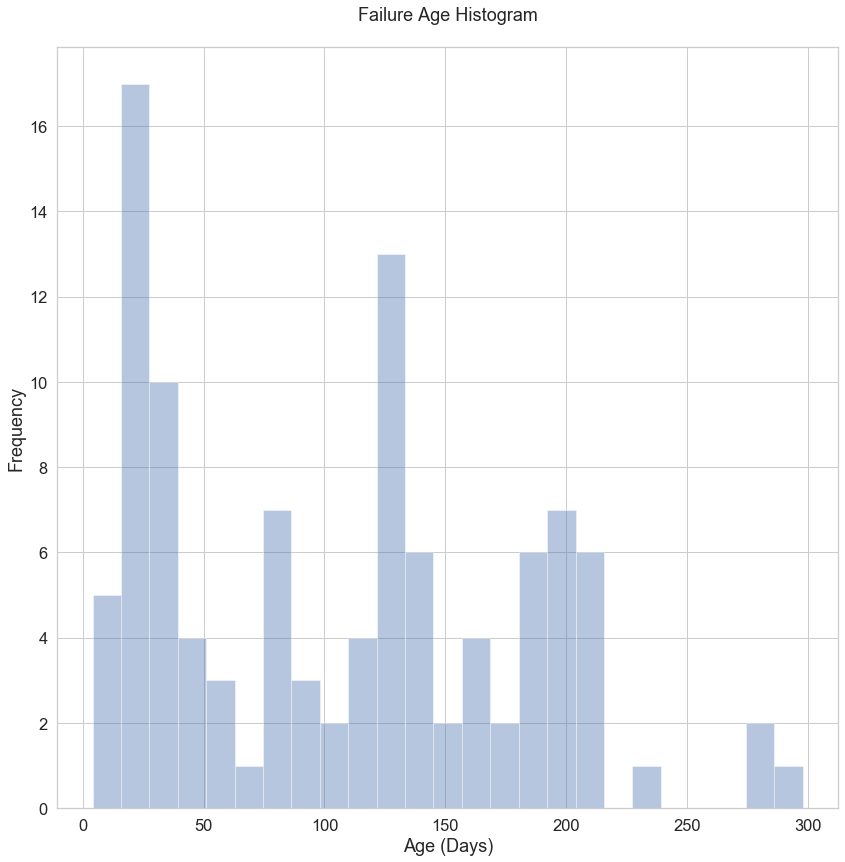

In [54]:
age_sql = \
'''
SELECT clean_telemetry.*, CAST(DATEDIFF(clean_telemetry.date, dates.min_date) AS DOUBLE) AS age
FROM clean_telemetry
LEFT JOIN (
    SELECT id, MIN(date) AS min_date 
    FROM clean_telemetry
    GROUP BY id
) AS dates
ON clean_telemetry.id =  dates.id
'''

failure_age_df = spark.sql('SELECT * FROM (' + age_sql + ') WHERE label = 1').toPandas()

sns.set(font_scale=1.5, style='whitegrid')
fig, ax = plt.subplots(figsize=(14,14))
sns.distplot(failure_age_df['age'], bins=25, kde=False, ax=ax)
ax.set_title('Failure Age Histogram\n')
ax.set_xlabel('Age (Days)')
ax.set_ylabel('Frequency');

### What do our min, max, mean, median, and stdev summary statistics look like?

#### Min

In [29]:
spark.sql(
'''
SELECT
    label,
    MIN(metric1) AS metric1,
    MIN(metric2) AS metric2,
    MIN(metric3) AS metric3,
    MIN(metric4) AS metric4,
    MIN(metric5) AS metric5,
    MIN(metric6) AS metric6,
    MIN(metric7) AS metric7,
    MIN(metric8) AS metric8,
    MIN(metric9) AS metric9,
    MIN(age) AS age
FROM (''' + age_sql + ''')
GROUP BY label
''').toPandas()

,label,metric1,metric2,metric3,metric4,...,metric6,metric7,metric8,metric9,age
0,1,4527376.0,0.0,0.0,0.0,...,24.0,0.0,0.0,0.0,4.0
1,0,0.0,0.0,0.0,0.0,...,8.0,0.0,0.0,0.0,0.0


#### Max

In [31]:
spark.sql(
'''
SELECT
    label,
    MAX(metric1) AS metric1,
    MAX(metric2) AS metric2,
    MAX(metric3) AS metric3,
    MAX(metric4) AS metric4,
    MAX(metric5) AS metric5,
    MAX(metric6) AS metric6,
    MAX(metric7) AS metric7,
    MAX(metric8) AS metric8,
    MAX(metric9) AS metric9,
    MAX(age) AS age
FROM (''' + age_sql + ''')
GROUP BY label
''').toPandas()

,label,metric1,metric2,metric3,metric4,...,metric6,metric7,metric8,metric9,age
0,1,243261216.0,64784.0,318.0,1666.0,...,574599.0,832.0,832.0,1165.0,298.0
1,0,244140480.0,64968.0,24929.0,1666.0,...,689161.0,832.0,832.0,18701.0,305.0


#### Mean

In [13]:
spark.sql(
'''
SELECT
    label,
    AVG(metric1) AS metric1,
    AVG(metric2) AS metric2,
    AVG(metric3) AS metric3,
    AVG(metric4) AS metric4,
    AVG(metric5) AS metric5,
    AVG(metric6) AS metric6,
    AVG(metric7) AS metric7,
    AVG(metric8) AS metric8,
    AVG(metric9) AS metric9,
    AVG(age) AS age
FROM (''' + age_sql + ''')
GROUP BY label
''').toPandas()

,label,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,age
0,1,1.271755e+08,4109.433962,3.905660,54.632075,15.462264,258303.481132,30.622642,30.622642,23.084906,106.905660
1,0,1.223840e+08,156.118725,9.945598,1.696048,14.221613,260174.250587,0.266682,0.266682,12.442462,105.142216


#### Median

In [32]:
spark.sql(
'''
SELECT
    label,
    PERCENTILE(metric1, 0.5) AS metric1,
    PERCENTILE(metric2, 0.5) AS metric2,
    PERCENTILE(metric3, 0.5) AS metric3,
    PERCENTILE(metric4, 0.5) AS metric4,
    PERCENTILE(metric5, 0.5) AS metric5,
    PERCENTILE(metric6, 0.5) AS metric6,
    PERCENTILE(metric7, 0.5) AS metric7,
    PERCENTILE(metric8, 0.5) AS metric8,
    PERCENTILE(metric9, 0.5) AS metric9,
    PERCENTILE(age, 0.5) AS age
FROM (''' + age_sql + ''')
GROUP BY label
''').toPandas()

,label,metric1,metric2,metric3,metric4,...,metric6,metric7,metric8,metric9,age
0,1,139117253.5,0.0,0.0,1.5,...,267648.5,0.0,0.0,0.0,113.0
1,0,122786072.0,0.0,0.0,0.0,...,249794.0,0.0,0.0,0.0,85.0


#### Standard Deviation

In [15]:
spark.sql(
'''
SELECT
    label,
    STDDEV_SAMP(metric1) AS metric1,
    STDDEV_SAMP(metric2) AS metric2,
    STDDEV_SAMP(metric3) AS metric3,
    STDDEV_SAMP(metric4) AS metric4,
    STDDEV_SAMP(metric5) AS metric5,
    STDDEV_SAMP(metric6) AS metric6,
    STDDEV_SAMP(metric7) AS metric7,
    STDDEV_SAMP(metric8) AS metric8,
    STDDEV_SAMP(metric9) AS metric9,
    STDDEV_SAMP(age) AS age
FROM (''' + age_sql + ''')
GROUP BY label
''').toPandas()

,label,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,age
0,1,6.940167e+07,12803.747239,31.557213,193.492528,15.547270,103349.308593,117.033610,117.033610,153.449984,74.017826
1,0,7.046036e+07,2145.521965,185.824103,22.164316,15.943381,99147.843106,6.558071,6.558071,191.455015,78.403974


### How many null values in each column?

In [34]:
spark.sql(
'''
SELECT
    SUM(CASE WHEN id IS NULL THEN 1 ELSE 0 END) AS id,
    SUM(CASE WHEN metric1 IS NULL THEN 1 ELSE 0 END) AS metric1,
    SUM(CASE WHEN metric2 IS NULL THEN 1 ELSE 0 END) AS metric2,
    SUM(CASE WHEN metric3 IS NULL THEN 1 ELSE 0 END) AS metric3,
    SUM(CASE WHEN metric4 IS NULL THEN 1 ELSE 0 END) AS metric4,
    SUM(CASE WHEN metric5 IS NULL THEN 1 ELSE 0 END) AS metric5,
    SUM(CASE WHEN metric6 IS NULL THEN 1 ELSE 0 END) AS metric6,
    SUM(CASE WHEN metric7 IS NULL THEN 1 ELSE 0 END) AS metric7,
    SUM(CASE WHEN metric8 IS NULL THEN 1 ELSE 0 END) AS metric8,
    SUM(CASE WHEN metric9 IS NULL THEN 1 ELSE 0 END) AS metric9
FROM clean_telemetry
''').toPandas()

,id,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,0,0,0,0,0,0,0,0,0,0


### What do our time histories look like?

In [5]:
clean_telemetry_sdf.createOrReplaceTempView('clean_telemetry')

In [6]:
failures_df = spark.sql(
'''
SELECT *
FROM clean_telemetry
WHERE id IN (
    SELECT id
    FROM clean_telemetry
    WHERE label = 1
)
ORDER BY id, date
''').toPandas()
failures_df['date'] = pd.to_datetime(failures_df['date'])

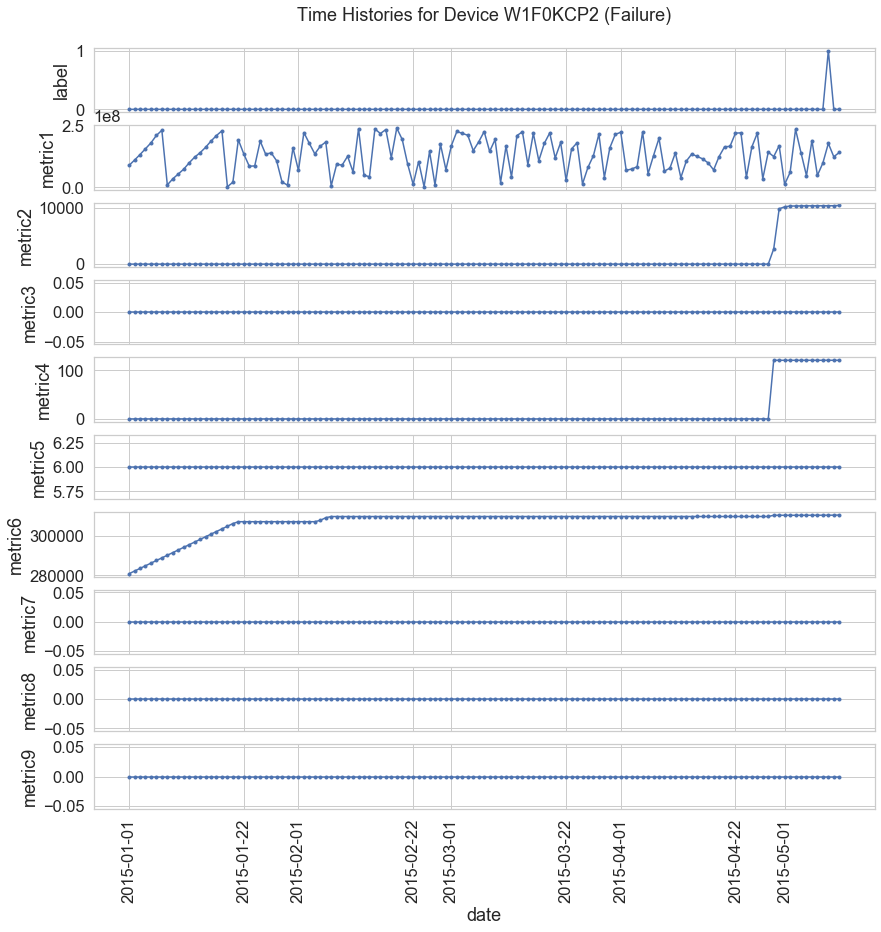

In [53]:
# failure_id = np.random.choice(failures_df['id'].unique())
failure_id = 'W1F0KCP2'
failure_df = failures_df.loc[failures_df['id']==failure_id]

sns.set(font_scale=1.5, style='whitegrid')
fig, axs = plt.subplots(nrows=10, ncols=1, sharex=True, figsize=(14,14))
axs[0].set_title('Time Histories for Device ' + failure_id + ' (Failure)\n')
axs[0].plot('date','label', data=failure_df, linestyle='-', marker='o', markersize=3); axs[0].set_ylabel('label')
axs[1].plot('date','metric1', data=failure_df, linestyle='-', marker='o', markersize=3); axs[1].set_ylabel('metric1')
axs[2].plot('date','metric2', data=failure_df, linestyle='-', marker='o', markersize=3); axs[2].set_ylabel('metric2')
axs[3].plot('date','metric3', data=failure_df, linestyle='-', marker='o', markersize=3); axs[3].set_ylabel('metric3')
axs[4].plot('date','metric4', data=failure_df, linestyle='-', marker='o', markersize=3); axs[4].set_ylabel('metric4')
axs[5].plot('date','metric5', data=failure_df, linestyle='-', marker='o', markersize=3); axs[5].set_ylabel('metric5')
axs[6].plot('date','metric6', data=failure_df, linestyle='-', marker='o', markersize=3); axs[6].set_ylabel('metric6')
axs[7].plot('date','metric7', data=failure_df, linestyle='-', marker='o', markersize=3); axs[7].set_ylabel('metric7')
axs[8].plot('date','metric8', data=failure_df, linestyle='-', marker='o', markersize=3); axs[8].set_ylabel('metric8')
axs[9].plot('date','metric9', data=failure_df, linestyle='-', marker='o', markersize=3); axs[9].set_ylabel('metric9'); axs[9].set_xlabel('date')
plt.xticks(rotation=90);

## Engineer Features

Given our data, we create the following "summary" features:
* Device level **age** in days.
* Device level **5-day moving average z-scores**.
* Device level first to last value **drifts**.
* Device level **5-day moving averages**.
* Device level **standard deviations**.
* Device level number of **readings**.

In [48]:
summary_sql = \
'''
SELECT
    *,
    -- Calculate device level label.
    MAX(date_level_label) OVER (PARTITION BY id) AS label,
    -- Calculate device level age in days.
    CAST(DATEDIFF(max_date, min_date) + 1 AS DOUBLE) AS age,
    -- Calculate device level 5-day moving average z-scores.
    COALESCE(AVG((metric1 - mean_metric1) / sd_metric1) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW),0) AS zs_metric1,
    COALESCE(AVG((metric2 - mean_metric2) / sd_metric2) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW),0) AS zs_metric2,
    COALESCE(AVG((metric3 - mean_metric3) / sd_metric3) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW),0) AS zs_metric3,
    COALESCE(AVG((metric4 - mean_metric4) / sd_metric4) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW),0) AS zs_metric4,
    COALESCE(AVG((metric5 - mean_metric5) / sd_metric5) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW),0) AS zs_metric5,
    COALESCE(AVG((metric6 - mean_metric6) / sd_metric6) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW),0) AS zs_metric6,
    COALESCE(AVG((metric7 - mean_metric7) / sd_metric7) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW),0) AS zs_metric7,
    COALESCE(AVG((metric8 - mean_metric8) / sd_metric8) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW),0) AS zs_metric8,
    COALESCE(AVG((metric9 - mean_metric9) / sd_metric9) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW),0) AS zs_metric9,
    -- Calculate device level first to last value drifts.
    (last_metric1 - first_metric1) AS drift_metric1,
    (last_metric2 - first_metric2) AS drift_metric2,
    (last_metric3 - first_metric3) AS drift_metric3,
    (last_metric4 - first_metric4) AS drift_metric4,
    (last_metric5 - first_metric5) AS drift_metric5,
    (last_metric6 - first_metric6) AS drift_metric6,
    (last_metric7 - first_metric7) AS drift_metric7,
    (last_metric8 - first_metric8) AS drift_metric8,
    (last_metric9 - first_metric9) AS drift_metric9
FROM (
    SELECT
        id,
        date,
        label AS date_level_label,
        metric1,
        metric2,
        metric3,
        metric4,
        metric5,
        metric6,
        metric7,
        metric8,
        metric9,
        -- Calculate device level averages.
        AVG(metric1) OVER (PARTITION BY id) AS mean_metric1,
        AVG(metric2) OVER (PARTITION BY id) AS mean_metric2,
        AVG(metric3) OVER (PARTITION BY id) AS mean_metric3,
        AVG(metric4) OVER (PARTITION BY id) AS mean_metric4,
        AVG(metric5) OVER (PARTITION BY id) AS mean_metric5,
        AVG(metric6) OVER (PARTITION BY id) AS mean_metric6,
        AVG(metric7) OVER (PARTITION BY id) AS mean_metric7,
        AVG(metric8) OVER (PARTITION BY id) AS mean_metric8,
        AVG(metric9) OVER (PARTITION BY id) AS mean_metric9,
        -- Calculate device level 5-day moving averages.
        AVG(metric1) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS ma_metric1,
        AVG(metric2) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS ma_metric2,
        AVG(metric3) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS ma_metric3,
        AVG(metric4) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS ma_metric4,
        AVG(metric5) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS ma_metric5,
        AVG(metric6) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS ma_metric6,
        AVG(metric7) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS ma_metric7,
        AVG(metric8) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS ma_metric8,
        AVG(metric9) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS ma_metric9,
        -- Calculate device level standard deviations.
        STDDEV_SAMP(metric1) OVER (PARTITION BY id) AS sd_metric1,
        STDDEV_SAMP(metric2) OVER (PARTITION BY id) AS sd_metric2,
        STDDEV_SAMP(metric3) OVER (PARTITION BY id) AS sd_metric3,
        STDDEV_SAMP(metric4) OVER (PARTITION BY id) AS sd_metric4,
        STDDEV_SAMP(metric5) OVER (PARTITION BY id) AS sd_metric5,
        STDDEV_SAMP(metric6) OVER (PARTITION BY id) AS sd_metric6,
        STDDEV_SAMP(metric7) OVER (PARTITION BY id) AS sd_metric7,
        STDDEV_SAMP(metric8) OVER (PARTITION BY id) AS sd_metric8,
        STDDEV_SAMP(metric9) OVER (PARTITION BY id) AS sd_metric9,
        -- Calculate device level first values.
        FIRST_VALUE(metric1) OVER (PARTITION BY id ORDER BY date ASC) AS first_metric1,
        FIRST_VALUE(metric2) OVER (PARTITION BY id ORDER BY date ASC) AS first_metric2,
        FIRST_VALUE(metric3) OVER (PARTITION BY id ORDER BY date ASC) AS first_metric3,
        FIRST_VALUE(metric4) OVER (PARTITION BY id ORDER BY date ASC) AS first_metric4,
        FIRST_VALUE(metric5) OVER (PARTITION BY id ORDER BY date ASC) AS first_metric5,
        FIRST_VALUE(metric6) OVER (PARTITION BY id ORDER BY date ASC) AS first_metric6,
        FIRST_VALUE(metric7) OVER (PARTITION BY id ORDER BY date ASC) AS first_metric7,
        FIRST_VALUE(metric8) OVER (PARTITION BY id ORDER BY date ASC) AS first_metric8,
        FIRST_VALUE(metric9) OVER (PARTITION BY id ORDER BY date ASC) AS first_metric9,
        -- Calculate device level last values.
        LAST_VALUE(metric1) OVER (PARTITION BY id ORDER BY date ASC) AS last_metric1,
        LAST_VALUE(metric2) OVER (PARTITION BY id ORDER BY date ASC) AS last_metric2,
        LAST_VALUE(metric3) OVER (PARTITION BY id ORDER BY date ASC) AS last_metric3,
        LAST_VALUE(metric4) OVER (PARTITION BY id ORDER BY date ASC) AS last_metric4,
        LAST_VALUE(metric5) OVER (PARTITION BY id ORDER BY date ASC) AS last_metric5,
        LAST_VALUE(metric6) OVER (PARTITION BY id ORDER BY date ASC) AS last_metric6,
        LAST_VALUE(metric7) OVER (PARTITION BY id ORDER BY date ASC) AS last_metric7,
        LAST_VALUE(metric8) OVER (PARTITION BY id ORDER BY date ASC) AS last_metric8,
        LAST_VALUE(metric9) OVER (PARTITION BY id ORDER BY date ASC) AS last_metric9,
        -- Calculate device level minimum date.
        MIN(date) OVER (PARTITION BY id) AS min_date,
        -- Calculate device level maximum date.
        MAX(date) OVER (PARTITION BY id) AS max_date,
        -- Count device level number of readings.
        CAST(COUNT(*) OVER (PARTITION BY id) AS DOUBLE) AS readings
    FROM clean_telemetry
)
WHERE date = max_date
AND sd_metric1 != 'NaN'
AND sd_metric2 != 'NaN'
AND sd_metric3 != 'NaN'
AND sd_metric4 != 'NaN'
AND sd_metric5 != 'NaN'
AND sd_metric6 != 'NaN'
AND sd_metric7 != 'NaN'
AND sd_metric8 != 'NaN'
AND sd_metric9 != 'NaN'
'''

summary_transformer = SQLTransformer(statement=summary_sql.replace('clean_telemetry','__THIS__'))
summary_sdf = summary_transformer.transform(clean_telemetry_sdf)
summary_sdf.select('*').limit(5).toPandas()

,id,date,date_level_label,metric1,metric2,...,drift_metric5,drift_metric6,drift_metric7,drift_metric8,drift_metric9
0,S1F0S02A,2015-01-13,0,143993216.0,0.0,...,0.0,11682.0,0.0,0.0,0.0
1,S1F1327G,2015-01-05,0,191647672.0,0.0,...,0.0,5341.0,0.0,0.0,0.0
2,W1F0PAXH,2015-07-11,1,198736232.0,0.0,...,2.0,34415.0,0.0,0.0,0.0
3,W1F11ZG9,2015-08-17,0,133230384.0,648.0,...,1.0,23440.0,0.0,0.0,0.0
4,W1F17RLV,2015-08-20,0,166352776.0,0.0,...,0.0,46687.0,0.0,0.0,0.0


In [49]:
transformers = [
    summary_transformer
]

transformed_sdf = SparkPipeline(stages=transformers).fit(clean_telemetry_sdf).transform(clean_telemetry_sdf)
transformed_cols = transformed_sdf.columns
transformed_sdf.printSchema()

root
 |-- id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- date_level_label: integer (nullable = true)
 |-- metric1: double (nullable = true)
 |-- metric2: double (nullable = true)
 |-- metric3: double (nullable = true)
 |-- metric4: double (nullable = true)
 |-- metric5: double (nullable = true)
 |-- metric6: double (nullable = true)
 |-- metric7: double (nullable = true)
 |-- metric8: double (nullable = true)
 |-- metric9: double (nullable = true)
 |-- mean_metric1: double (nullable = true)
 |-- mean_metric2: double (nullable = true)
 |-- mean_metric3: double (nullable = true)
 |-- mean_metric4: double (nullable = true)
 |-- mean_metric5: double (nullable = true)
 |-- mean_metric6: double (nullable = true)
 |-- mean_metric7: double (nullable = true)
 |-- mean_metric8: double (nullable = true)
 |-- mean_metric9: double (nullable = true)
 |-- ma_metric1: double (nullable = true)
 |-- ma_metric2: double (nullable = true)
 |-- ma_metric3: double (nullable = true)
 |-- 

## Correlations

As can be seen in the correlation plot below, metrics 7 and 8 are highly (perfectly) correlated. So we'll only consider one of these feaures in modeling. We'll pick metric 7 and drop metric 8. Also, as expected, device age and number of readings are highly correlated. So we'll pick device age and drop number of readings. We'll also drop the last value of each metric (i.e. metric1, etc.) and the device level mean of each metric (i.e. mean_metric1, etc.) in favor of the 5-day moving average mean of each metric (i.e. ma_metric1, etc.), since they are all highly correlated.

In [50]:
correlation_cols = sorted(
    list(
        set(transformed_cols) -
        {'id','date','date_level_label','min_date','max_date'} -
        set([col for col in transformed_cols if 'first' in col]) -
        set([col for col in transformed_cols if 'last' in col])
    )
)
correlation_assembler = VectorAssembler(inputCols=correlation_cols, outputCol='features')
correlation_features = correlation_assembler.transform(transformed_sdf)
correlation_sdm = Correlation.corr(correlation_features, 'features').head()[0]
correlation_array = correlation_sdm.toArray()
correlation_df = pd.DataFrame(data=correlation_array, index=correlation_cols, columns=correlation_cols)

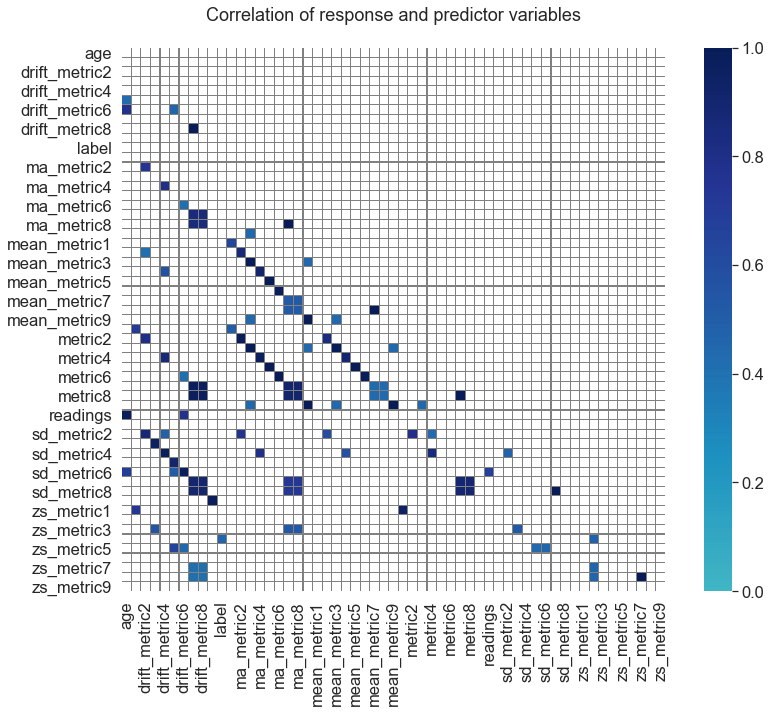

In [52]:
correlation_mask = np.zeros_like(correlation_df.values)
correlation_mask[correlation_df.values < 0.4] = True
correlation_mask[np.triu_indices_from(correlation_mask)] = True

sns.set(font_scale=1.5, style='whitegrid')
fig, ax = plt.subplots(figsize=(14,10))
ax.set_title('Correlation of response and predictor variables\n')
sns.heatmap(correlation_df, mask=correlation_mask, center=0, vmin=0, vmax=1, linewidths=.1, linecolor='gray', cmap='YlGnBu', square=True, ax=ax);

## Stratified Train / Test Split

In [128]:
train_pct = 0.8
test_pct = 1 - train_pct

telemetry_0 = spark.sql(
'''
SELECT
    *
FROM clean_telemetry
WHERE label = 0
''')
telemetry_0_train, telemetry_0_test = telemetry_0.randomSplit([train_pct, test_pct])

telemetry_1 = spark.sql(
'''
SELECT
    *
FROM clean_telemetry
WHERE label = 1
''')
telemetry_1_train, telemetry_1_test = telemetry_1.randomSplit([train_pct, test_pct])

train_sdf = telemetry_0_train.union(telemetry_1_train)
test_sdf = telemetry_0_test.union(telemetry_1_test)

In [129]:
train_sdf.groupBy('label').count().toPandas()

,label,count
0,1,91
1,0,99277


In [130]:
test_sdf.groupBy('label').count().toPandas()

,label,count
0,1,15
1,0,25111


## Machine Learning Pipeline

In [131]:
feature_cols = sorted(
    list(
        set(transformed_cols) -
        {'id','date','label','date_level_label','min_date','max_date'} -
        set([col for col in transformed_cols if 'first' in col]) -
        set([col for col in transformed_cols if 'last' in col]) -
        # Subtract correlated features.
        set([col for col in transformed_cols if 'metric8' in col]) -
        {'readings'} -
        {'metric1','metric2','metric3','metric4','metric5','metric6','metric7','metric8','metric9'} -
        set([col for col in transformed_cols if 'mean' in col])
    )
)
print(feature_cols)

['age', 'drift_metric1', 'drift_metric2', 'drift_metric3', 'drift_metric4', 'drift_metric5', 'drift_metric6', 'drift_metric7', 'drift_metric9', 'ma_metric1', 'ma_metric2', 'ma_metric3', 'ma_metric4', 'ma_metric5', 'ma_metric6', 'ma_metric7', 'ma_metric9', 'sd_metric1', 'sd_metric2', 'sd_metric3', 'sd_metric4', 'sd_metric5', 'sd_metric6', 'sd_metric7', 'sd_metric9', 'zs_metric1', 'zs_metric2', 'zs_metric3', 'zs_metric4', 'zs_metric5', 'zs_metric6', 'zs_metric7', 'zs_metric9']


In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from spark_sklearn import GridSearchCV

In [133]:
feature_pipeline = SparkPipeline(stages=transformers)

feature_train_sdf = feature_pipeline.fit(train_sdf).transform(train_sdf)
feature_test_sdf = feature_pipeline.fit(test_sdf).transform(test_sdf)

train_df = feature_train_sdf.toPandas()
test_df = feature_test_sdf.toPandas()

X_train = train_df[feature_cols].values
X_test = test_df[feature_cols].values

y_train = train_df['label'].values
y_test = test_df['label'].values

## Model Selection using Cross Validation with spark-sklearn

In [146]:
# Specify parameters to grid search over.
parameters = {'criterion':('gini','entropy'),'n_estimators':[100,200,300,400,500],'max_depth':[1,2,3]}
# Specify balanced class weighting.
rf = RandomForestClassifier(class_weight='balanced')
# Specify stratified 5-fold cross validation.
skf = StratifiedKFold(n_splits=5, shuffle=True)
# Train and evaluate models in parallel using Spark.
clf = GridSearchCV(sc, rf, parameters, scoring='roc_auc', cv=skf)
clf.fit(X_train, y_train);

In [147]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [148]:
# Predict train and test probabilities.
y_train_proba = clf.best_estimator_.predict_proba(X_train)[:,1]
y_test_proba = clf.best_estimator_.predict_proba(X_test)[:,1]

## Confusion Summary

In [149]:
def confusion_summary(y_true, y_proba, thresholds=[0.5]):
    
    confusion_summaries_df = pd.DataFrame(columns=['Threshold','TP','TN','FP','FN','Accuracy','Precision','Recall','F1','AUC'])
    
    for threshold in thresholds:

        y_pred = np.zeros_like(y_proba)
        y_pred[y_proba > threshold] = True

        # True Positive (TP): Predict a label of 1 and the true label is 1.
        TP = np.sum(np.logical_and(y_pred == 1, y_true == 1))

        # True Negative (TN): Predict a label of 0 and the true label is 0.
        TN = np.sum(np.logical_and(y_pred == 0, y_true == 0))

        # False Positive (FP): Predict a label of 1 and the true label is 0.
        FP = np.sum(np.logical_and(y_pred == 1, y_true == 0))

        # False Negative (FN): Predict a label of 0 and the true label is 1.
        FN = np.sum(np.logical_and(y_pred == 0, y_true == 1))
        
        # Accuracy: How often are we right?
        accuracy = (TP + TN) / (TP + TN + FP + FN)

        # Precision: How often are we right when we predict failure?
        precision = TP / (TP + FP)

        # Recall: How often do we catch failures?
        recall = TP / (TP + FN)
        
        # F1: Harmonic mean of precision and recall.
        F1 = 2*TP / (2*TP + FP + FN)
        
        confusion_summaries_df = confusion_summaries_df.append({'Threshold':threshold,'TP':TP,'TN':TN,'FP':FP,'FN':FN,'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1':F1}, ignore_index=True)
        
    confusion_summaries_df['AUC'] = roc_auc_score(y_true, y_proba)

    return confusion_summaries_df

### Train Summary

In [150]:
confusion_summary(y_train, y_train_proba, thresholds=[0.2,0.3,0.4,0.5,0.6,0.7,0.8])

,Threshold,TP,TN,FP,FN,Accuracy,Precision,Recall,F1,AUC
0,0.2,88.0,307.0,772.0,0.0,0.338475,0.102326,1.000000,0.185654,0.954377
1,0.3,87.0,642.0,437.0,1.0,0.624679,0.166031,0.988636,0.284314,0.954377
2,0.4,69.0,999.0,80.0,19.0,0.915167,0.463087,0.784091,0.582278,0.954377
3,0.5,67.0,1026.0,53.0,21.0,0.936590,0.558333,0.761364,0.644231,0.954377
4,0.6,58.0,1044.0,35.0,30.0,0.944302,0.623656,0.659091,0.640884,0.954377
5,0.7,50.0,1063.0,16.0,38.0,0.953728,0.757576,0.568182,0.649351,0.954377
6,0.8,33.0,1071.0,8.0,55.0,0.946015,0.804878,0.375000,0.511628,0.954377


### Test Summary

In [151]:
confusion_summary(y_test, y_test_proba, thresholds=[0.2,0.3,0.4,0.5,0.6,0.7,0.8])

,Threshold,TP,TN,FP,FN,Accuracy,Precision,Recall,F1,AUC
0,0.2,14.0,123.0,784.0,0.0,0.148751,0.017544,1.000000,0.034483,0.907269
1,0.3,14.0,414.0,493.0,0.0,0.464712,0.027613,1.000000,0.053743,0.907269
2,0.4,9.0,795.0,112.0,5.0,0.872964,0.074380,0.642857,0.133333,0.907269
3,0.5,8.0,828.0,79.0,6.0,0.907709,0.091954,0.571429,0.158416,0.907269
4,0.6,7.0,850.0,57.0,7.0,0.930510,0.109375,0.500000,0.179487,0.907269
5,0.7,7.0,868.0,39.0,7.0,0.950054,0.152174,0.500000,0.233333,0.907269
6,0.8,6.0,889.0,18.0,8.0,0.971770,0.250000,0.428571,0.315789,0.907269


Train/test ROC AUC's are similar. So overfitting is not too bad. Could be improved. Optimal threshold can be decided by client based on cost of a false alarm and cost of a miss.

## Feature Importances

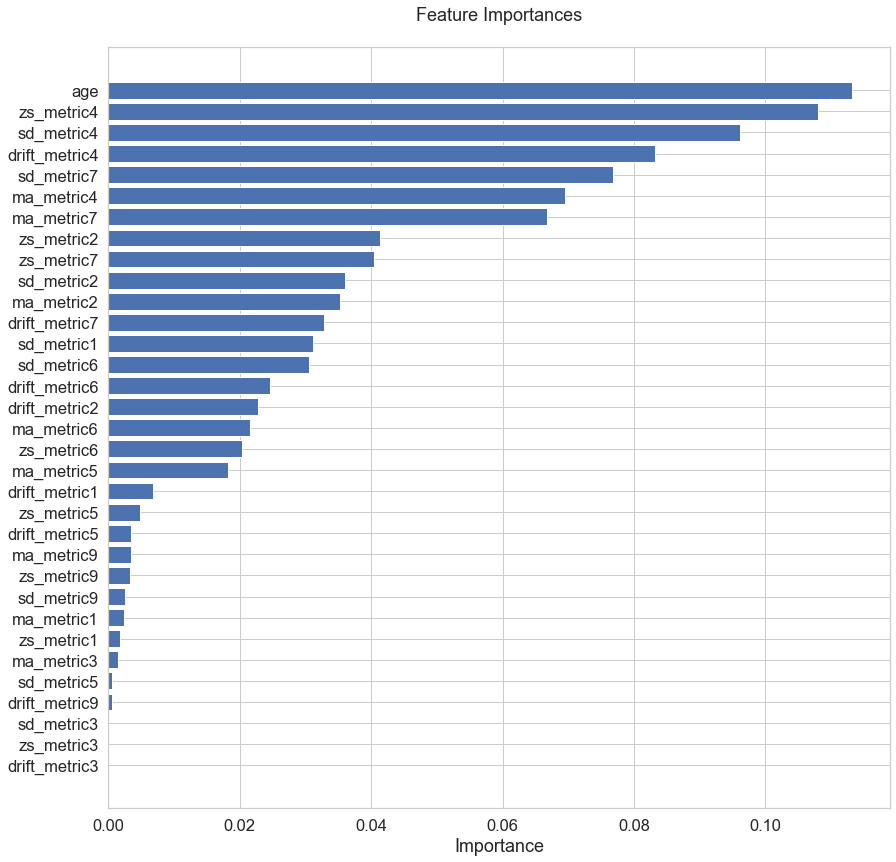

In [152]:
# Extract feature importances.
feature_imps = list(clf.best_estimator_.feature_importances_)

# Create feature importances dataframe.
feature_importances_df = pd.DataFrame(columns=['Feature','Importance'])
for feature, importance in zip(feature_cols,feature_imps):
    feature_importances_df = feature_importances_df.append({'Feature':feature,'Importance':importance}, ignore_index=True)
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot feature importances.
sns.set(font_scale=1.5, style='whitegrid')
fig, ax = plt.subplots(figsize=(14,14))
ax.set_title('Feature Importances\n')
ax.set_xlabel('Importance')
ax.barh('Feature', 'Importance', data=feature_importances_df, align='center')
ax.invert_yaxis()